In [ ]:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from datetime import datetime

In [ ]:
list_names = []

with os.scandir() as scanner:
    list_files = list(scanner)
    file_name = list_files[0].name

with open ('/content/drive/MyDrive/data_science/Projeto_integrado/20100415.MTPCH.csv', encoding = "ISO-8859-1") as arquivo:
    dados_csv_diarios = arquivo.readlines()
    
cabecalho = dados_csv_diarios[1]

cabecalho = re.sub(r';;', ';', cabecalho)
cabecalho = re.sub(r';\n', '', cabecalho)
cabecalho = re.sub(r'MTPC-', '', cabecalho)

cabecalho = cabecalho.split(';')

for i, nome in enumerate(cabecalho):
    cabecalho[i] = nome.lower()

# print(cabecalho)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_science/Projeto_integrado/dados_analisados.csv', names=cabecalho, sep=';')

df = df.replace('-', np.nan)
df.head(5)

,data,hora,pluh,contpluh,tempar,tempmax,tempmin,umidade,pressao,radiacao,velvento,dpvelvento,dirvento,velrajada,dirrajada,horrajada
0,19/06/2011,1,0.0,827.8,8.3,9.3,8.2,98,874.6,0.00,1.4,0.2,180,2.4,190,43
1,19/06/2011,2,0.0,827.8,8.2,8.5,7.8,97,874.4,0.00,0.8,0.6,184,2.1,186,3
2,19/06/2011,3,0.0,827.8,7.9,8.0,7.1,98,874.0,0.00,0.6,0.2,189,1.8,178,0
3,19/06/2011,4,0.0,827.8,7.1,7.7,7.1,98,873.9,0.00,1.0,0.2,183,2.1,184,32
4,19/06/2011,5,0.0,827.8,7.1,7.4,7.0,98,873.6,0.00,0.5,0.2,235,1.7,180,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88959 entries, 0 to 88958
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   data        88959 non-null  object
 1   hora        88959 non-null  int64 
 2   pluh        88573 non-null  object
 3   contpluh    88078 non-null  object
 4   tempar      87749 non-null  object
 5   tempmax     87314 non-null  object
 6   tempmin     87307 non-null  object
 7   umidade     80957 non-null  object
 8   pressao     88709 non-null  object
 9   radiacao    88710 non-null  object
 10  velvento    84829 non-null  object
 11  dpvelvento  74460 non-null  object
 12  dirvento    74460 non-null  object
 13  velrajada   74466 non-null  object
 14  dirrajada   74466 non-null  object
 15  horrajada   74466 non-null  object
dtypes: int64(1), object(15)
memory usage: 10.9+ MB


In [ ]:
df.drop(['contpluh', 'tempmax', 'tempmin', 'dpvelvento', 'dirvento', 'velrajada', 'dirrajada', 'horrajada'], axis=1, inplace=True)
df.head(5)

,data,hora,pluh,tempar,umidade,pressao,radiacao,velvento
0,19/06/2011,1,0.0,8.3,98,874.6,0.00,1.4
1,19/06/2011,2,0.0,8.2,97,874.4,0.00,0.8
2,19/06/2011,3,0.0,7.9,98,874.0,0.00,0.6
3,19/06/2011,4,0.0,7.1,98,873.9,0.00,1.0
4,19/06/2011,5,0.0,7.1,98,873.6,0.00,0.5


In [ ]:
cols = ['pluh', 'tempar', 'umidade', 'pressao', 'radiacao', 'velvento']
df[cols] = df[cols].astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88959 entries, 0 to 88958
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   data      88959 non-null  object 
 1   hora      88959 non-null  int64  
 2   pluh      88573 non-null  float32
 3   tempar    87749 non-null  float32
 4   umidade   80957 non-null  float32
 5   pressao   88709 non-null  float32
 6   radiacao  88710 non-null  float32
 7   velvento  84829 non-null  float32
dtypes: float32(6), int64(1), object(1)
memory usage: 3.4+ MB


In [ ]:
def transf(d):
    data = d.split('/')
    data = data[2]+'-'+data[1]+'-'+data[0]
    return data

df['data'] = df['data'].apply(transf)
df.head(5)

,data,hora,pluh,tempar,umidade,pressao,radiacao,velvento
0,2011-06-19,1,0.0,8.3,98.0,874.599976,0.0,1.4
1,2011-06-19,2,0.0,8.2,97.0,874.400024,0.0,0.8
2,2011-06-19,3,0.0,7.9,98.0,874.000000,0.0,0.6
3,2011-06-19,4,0.0,7.1,98.0,873.900024,0.0,1.0
4,2011-06-19,5,0.0,7.1,98.0,873.599976,0.0,0.5


In [ ]:
df['datetime'] = pd.to_datetime(df.data) + pd.to_timedelta(df.hora, unit='h')
df.head(5)

,data,hora,pluh,tempar,umidade,pressao,radiacao,velvento,datetime
0,2011-06-19,1,0.0,8.3,98.0,874.599976,0.0,1.4,2011-06-19 01:00:00
1,2011-06-19,2,0.0,8.2,97.0,874.400024,0.0,0.8,2011-06-19 02:00:00
2,2011-06-19,3,0.0,7.9,98.0,874.000000,0.0,0.6,2011-06-19 03:00:00
3,2011-06-19,4,0.0,7.1,98.0,873.900024,0.0,1.0,2011-06-19 04:00:00
4,2011-06-19,5,0.0,7.1,98.0,873.599976,0.0,0.5,2011-06-19 05:00:00


In [ ]:
df.drop(['data', 'hora'], axis=1, inplace=True)
df.head(5)

,pluh,tempar,umidade,pressao,radiacao,velvento,datetime
0,0.0,8.3,98.0,874.599976,0.0,1.4,2011-06-19 01:00:00
1,0.0,8.2,97.0,874.400024,0.0,0.8,2011-06-19 02:00:00
2,0.0,7.9,98.0,874.000000,0.0,0.6,2011-06-19 03:00:00
3,0.0,7.1,98.0,873.900024,0.0,1.0,2011-06-19 04:00:00
4,0.0,7.1,98.0,873.599976,0.0,0.5,2011-06-19 05:00:00


In [ ]:
columns = ['datetime', 'pluh', 'tempar', 'umidade', 'pressao', 'radiacao', 'velvento']

df = df.reindex(columns=columns)
df.head()

,datetime,pluh,tempar,umidade,pressao,radiacao,velvento
0,2011-06-19 01:00:00,0.0,8.3,98.0,874.599976,0.0,1.4
1,2011-06-19 02:00:00,0.0,8.2,97.0,874.400024,0.0,0.8
2,2011-06-19 03:00:00,0.0,7.9,98.0,874.000000,0.0,0.6
3,2011-06-19 04:00:00,0.0,7.1,98.0,873.900024,0.0,1.0
4,2011-06-19 05:00:00,0.0,7.1,98.0,873.599976,0.0,0.5


In [ ]:
df.describe()

,pluh,tempar,umidade,pressao,radiacao,velvento
count,88573.000000,87749.000000,80957.000000,88709.000000,88710.000000,84829.000000
mean,0.199364,20.661768,77.320946,873.973389,0.649687,2.132546
std,4.988785,7.388261,21.563862,2.831884,0.952542,1.353726
min,0.000000,-30.000000,4.000000,863.500000,0.000000,0.000000
25%,0.000000,16.400000,62.000000,872.200012,0.000000,1.000000
50%,0.000000,19.400000,82.000000,873.900024,0.030000,2.000000
75%,0.000000,23.400000,96.000000,875.799988,1.160000,3.100000
max,999.200012,60.000000,110.000000,884.500000,4.040000,13.100000


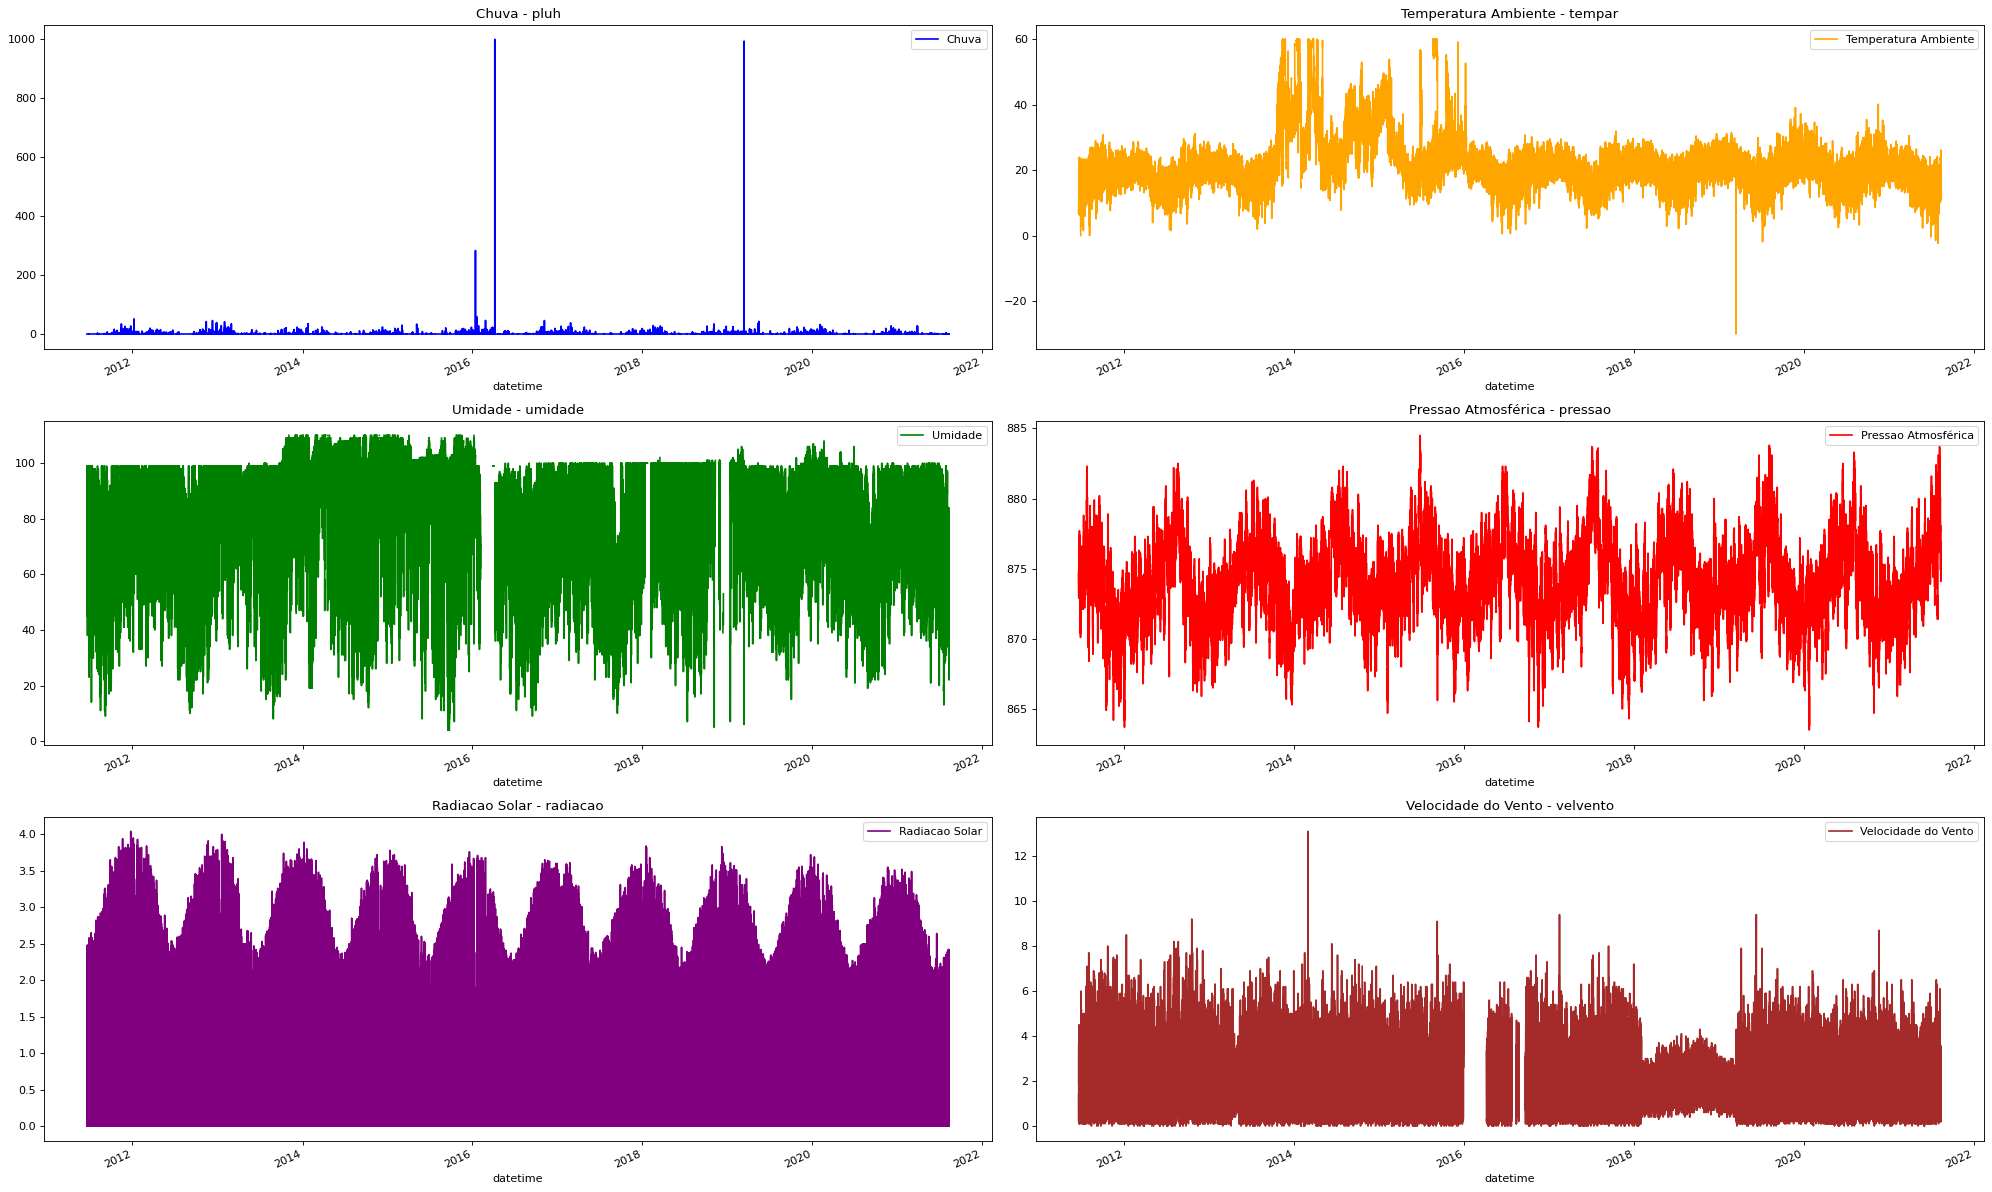

In [ ]:
titles = ['Chuva', 'Temperatura Ambiente', 'Umidade', 'Pressao Atmosférica', 'Radiacao Solar', 'Velocidade do Vento']
feature_keys = ['pluh', 'tempar', 'umidade', 'pressao', 'radiacao', 'velvento']
colors = ["blue", "orange", "green", "red", "purple", "brown"]

date_time_key = "datetime"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=3, ncols=2, figsize=(25, 15), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()

df_plot = df.copy()
show_raw_visualization(df_plot)

In [ ]:
df.query("umidade > 100").count()

datetime    6543
pluh        6532
tempar      6466
umidade     6543
pressao     6543
radiacao    6543
velvento    6302
dtype: int64

In [ ]:
print(df['umidade'].max())
df.loc[df.umidade > 100, 'umidade'] = 100
df['umidade'].max()

110.0


100.0

In [ ]:
df.query("umidade > 100").count()

datetime    0
pluh        0
tempar      0
umidade     0
pressao     0
radiacao    0
velvento    0
dtype: int64

In [ ]:
print(df['tempar'].max())
print(df['tempar'].min())
print('\n')
df.query("tempar > 36").count()

60.0
-30.0




datetime    4230
pluh        4214
tempar      4230
umidade     2936
pressao     4230
radiacao    4230
velvento    4213
dtype: int64

In [ ]:
df.query("tempar < 0").count()

datetime    22
pluh        22
tempar      22
umidade     22
pressao     22
radiacao    22
velvento    22
dtype: int64

In [ ]:
df.loc[df.tempar > 35, 'tempar'] = 35
df.loc[df.tempar < 0, 'tempar'] = 0

print(df['tempar'].max())
print(df['tempar'].min())

35.0
0.0


In [ ]:
df.query("tempar > 36").count()

datetime    0
pluh        0
tempar      0
umidade     0
pressao     0
radiacao    0
velvento    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88959 entries, 0 to 88958
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  88959 non-null  datetime64[ns]
 1   pluh      88573 non-null  float32       
 2   tempar    87749 non-null  float32       
 3   umidade   80957 non-null  float32       
 4   pressao   88709 non-null  float32       
 5   radiacao  88710 non-null  float32       
 6   velvento  84829 non-null  float32       
dtypes: datetime64[ns](1), float32(6)
memory usage: 2.7 MB


In [ ]:
df['umidade'].interpolate(method='pad', inplace=True)
df['tempar'].interpolate(method='pad', inplace=True)
df['radiacao'].interpolate(method='pad', inplace=True)
df['pressao'].interpolate(method='pad', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88959 entries, 0 to 88958
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  88959 non-null  datetime64[ns]
 1   pluh      88573 non-null  float32       
 2   tempar    88959 non-null  float32       
 3   umidade   88959 non-null  float32       
 4   pressao   88959 non-null  float32       
 5   radiacao  88959 non-null  float32       
 6   velvento  84829 non-null  float32       
dtypes: datetime64[ns](1), float32(6)
memory usage: 2.7 MB


In [ ]:
chuvas = df['pluh'].sort_values(ascending=False)
chuvas.head(15)

42082    999.200012
67804    993.200012
40087    283.000000
40215     59.000000
4861      51.200001
41125     46.000000
12954     45.599998
47198     45.599998
69323     42.799999
12314     42.200001
14201     41.400002
47199     39.599998
13385     38.799999
49900     38.000000
69246     36.400002
Name: pluh, dtype: float32

In [ ]:
df.loc[df.pluh > 50, 'pluh'] = 0

chuvas = df['pluh'].sort_values(ascending=False)
chuvas.head(15)

41125    46.000000
12954    45.599998
47198    45.599998
69323    42.799999
12314    42.200001
14201    41.400002
47199    39.599998
13385    38.799999
49900    38.000000
69246    36.400002
22816    35.000000
13335    34.799999
14905    34.599998
64688    34.200001
3558     34.200001
Name: pluh, dtype: float32

In [ ]:
df['pluh'].interpolate(method='pad', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88959 entries, 0 to 88958
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  88959 non-null  datetime64[ns]
 1   pluh      88959 non-null  float32       
 2   tempar    88959 non-null  float32       
 3   umidade   88959 non-null  float32       
 4   pressao   88959 non-null  float32       
 5   radiacao  88959 non-null  float32       
 6   velvento  84829 non-null  float32       
dtypes: datetime64[ns](1), float32(6)
memory usage: 2.7 MB


In [ ]:
df.query("velvento > 7").count()

datetime    83
pluh        83
tempar      83
umidade     83
pressao     83
radiacao    83
velvento    83
dtype: int64

In [ ]:
df.loc[df.velvento > 7, 'velvento'] = 7
df.query("velvento > 7").count()

datetime    0
pluh        0
tempar      0
umidade     0
pressao     0
radiacao    0
velvento    0
dtype: int64

In [ ]:
df['velvento'].fillna(value=df['velvento'].mean(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88959 entries, 0 to 88958
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  88959 non-null  datetime64[ns]
 1   pluh      88959 non-null  float32       
 2   tempar    88959 non-null  float32       
 3   umidade   88959 non-null  float32       
 4   pressao   88959 non-null  float32       
 5   radiacao  88959 non-null  float32       
 6   velvento  88959 non-null  float32       
dtypes: datetime64[ns](1), float32(6)
memory usage: 2.7 MB


In [ ]:
df.describe()

,pluh,tempar,umidade,pressao,radiacao,velvento
count,88959.000000,88959.000000,88959.000000,88959.000000,88959.000000,88959.000000
mean,0.173925,20.437325,78.650215,873.970703,0.648084,2.131873
std,1.241004,6.396616,21.063080,2.834748,0.952247,1.319079
min,0.000000,0.000000,4.000000,863.500000,0.000000,0.000000
25%,0.000000,16.450000,65.000000,872.200012,0.000000,1.100000
50%,0.000000,19.400000,85.000000,873.900024,0.030000,2.100000
75%,0.000000,23.600000,98.000000,875.799988,1.150000,3.000000
max,46.000000,35.000000,100.000000,884.500000,4.040000,7.000000


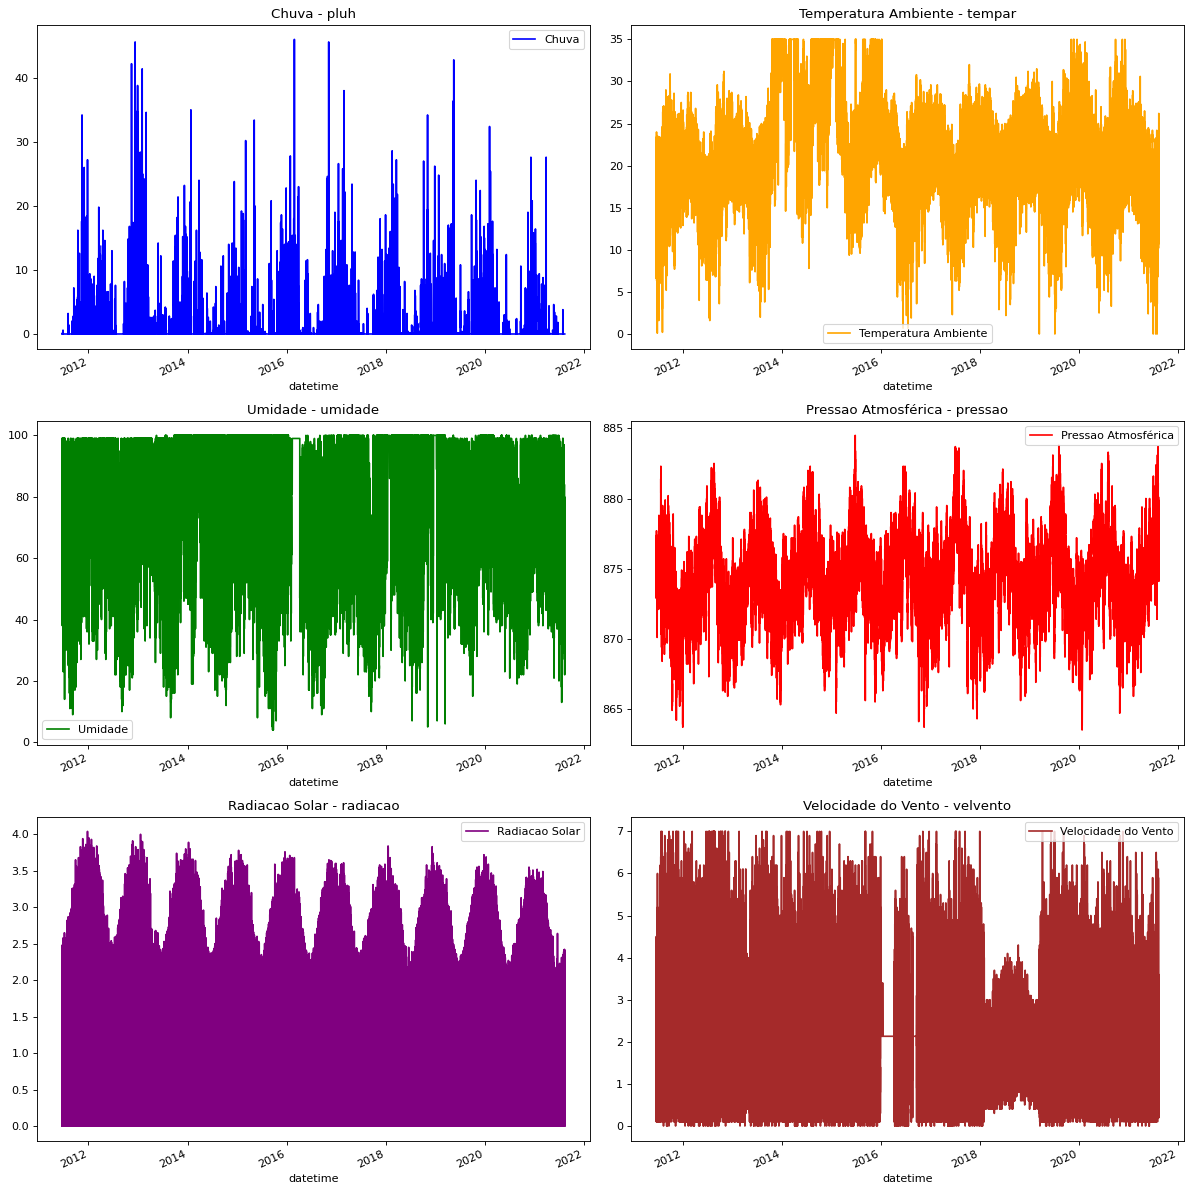

In [ ]:
titles = ['Chuva', 'Temperatura Ambiente', 'Umidade', 'Pressao Atmosférica', 'Radiacao Solar', 'Velocidade do Vento']
feature_keys = ['pluh', 'tempar', 'umidade', 'pressao', 'radiacao', 'velvento']
colors = ["blue", "orange", "green", "red", "purple", "brown"]

date_time_key = "datetime"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=3, ncols=2, figsize=(15, 15), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()

df_plot = df.copy()
show_raw_visualization(df_plot)

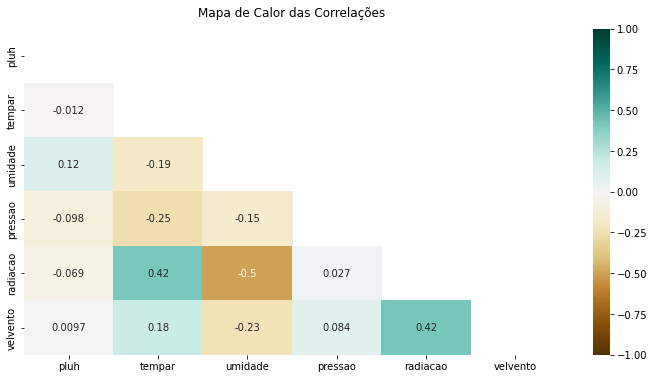

In [ ]:
df_corr = df.copy()

plt.figure(figsize=(12, 6))

mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))

heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Mapa de Calor das Correlações', fontdict={'fontsize':12}, pad=12);

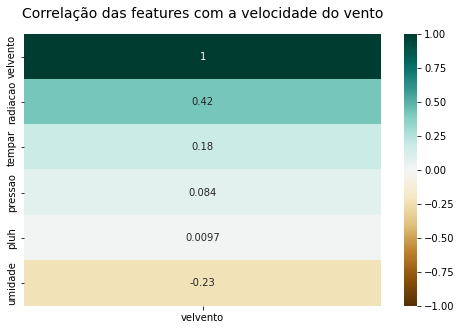

In [ ]:
df_corr.corr()[['velvento']].sort_values(by='velvento', ascending=False)

plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(df_corr.corr()[['velvento']].sort_values(by='velvento', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlação das features com a velocidade do vento', fontdict={'fontsize':14}, pad=16);

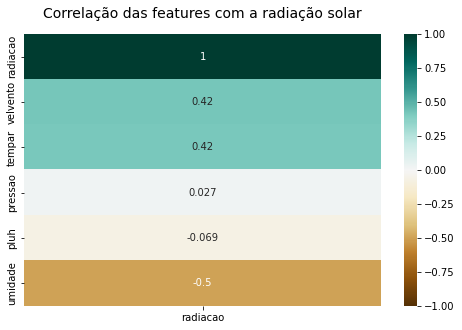

In [ ]:
df_corr.corr()[['radiacao']].sort_values(by='radiacao', ascending=False)

plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(df_corr.corr()[['radiacao']].sort_values(by='radiacao', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlação das features com a radiação solar', fontdict={'fontsize':14}, pad=16);

In [ ]:
df.drop(['datetime', 'pluh', 'pressao'], axis=1, inplace=True)
df.head(5)

,tempar,umidade,radiacao,velvento
0,8.3,98.0,0.0,1.4
1,8.2,97.0,0.0,0.8
2,7.9,98.0,0.0,0.6
3,7.1,98.0,0.0,1.0
4,7.1,98.0,0.0,0.5


In [ ]:
df_bkp = df.copy()
# df = df_bkp.copy()

In [ ]:
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# Funcao para geracao da serie temporal exigida pelo modelo RNN
def df_to_temporal_serie(data, n_in=1, n_out=1, dropnan=True):
	"""
	Ajusta uma serie temporal como um dataframe adequado para o modelo RNN
	Argumentos:
		data: Sequencia de observacoes (lista ou array Numpy).
		n_in: Lag das observacoes de entrada (X).
		n_out: Numero de observacoes de saida (y).
		dropnan: Flag para remocao ou nao dos linhas com dados nulos (True = remocao).
	Retorna:
		Dataframe Pandas com os dados preparados como serie temporal.
	"""

	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
 	
	 # Sequencia de entrada dos dados (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	
	# Sequencia da serie temporal (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	# Agrupa os elementos em um dataframe unico
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	
	# Remove as linhas com valores nulos
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
values = df.values

# Normaliza as features do dataset para valores adequados ao modelo
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# Aplica a funcao de criacao dos frames de tempo no dataset normalizado
reframed = df_to_temporal_serie(scaled, 1, 1)

In [ ]:
# Remove as colunas que nao se deseja predizer (temperatura, umidade e velocidade do vento deslocadas )
reframed_radiacao = reframed.drop(reframed.columns[[4, 5, 7]], axis=1)

print('      tempar    umidade   radiacao   velvento   radiacao_desl')
reframed_radiacao.head(10)

      tempar    umidade   radiacao   velvento   radiacao_desl


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var3(t)
1,0.237143,0.979167,0.000000,0.200000,0.000000
2,0.234286,0.968750,0.000000,0.114286,0.000000
3,0.225714,0.979167,0.000000,0.085714,0.000000
4,0.202857,0.979167,0.000000,0.142857,0.000000
5,0.202857,0.979167,0.000000,0.071429,0.000000
6,0.188571,0.989583,0.000000,0.157143,0.002475
7,0.188571,0.979167,0.002475,0.128571,0.049505
8,0.282857,0.895833,0.049505,0.028571,0.165842
9,0.405714,0.645833,0.165842,0.342857,0.425743
10,0.468571,0.562500,0.425743,0.371429,0.542079


In [ ]:
# Remove as colunas que nao se deseja predizer (temperatura, umidade e radiacao solar deslocadas )
reframed_velvento = reframed.drop(reframed.columns[[4, 5, 6]], axis=1)

print('      tempar    umidade   radiacao   velvento    velvento_desl')
reframed_velvento.head(10)

      tempar    umidade   radiacao   velvento    velvento_desl


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
1,0.237143,0.979167,0.000000,0.200000,0.114286
2,0.234286,0.968750,0.000000,0.114286,0.085714
3,0.225714,0.979167,0.000000,0.085714,0.142857
4,0.202857,0.979167,0.000000,0.142857,0.071429
5,0.202857,0.979167,0.000000,0.071429,0.157143
6,0.188571,0.989583,0.000000,0.157143,0.128571
7,0.188571,0.979167,0.002475,0.128571,0.028571
8,0.282857,0.895833,0.049505,0.028571,0.342857
9,0.405714,0.645833,0.165842,0.342857,0.371429
10,0.468571,0.562500,0.425743,0.371429,0.414286


In [ ]:
values_radiacao = reframed_radiacao.values
split_fraction_radiacao = 0.8

# Divide o dataset em sets de treino e de teste
train_size_radiacao = int(len(values_radiacao) * split_fraction_radiacao)
train_radiacao = values_radiacao[:train_size_radiacao, :]
test_radiacao = values_radiacao[train_size_radiacao:, :]

# Divide os sets de treino e de teste em entradas e saidas
train_X_radiacao, train_y_radiacao = train_radiacao[:, :-1], train_radiacao[:, -1]
test_X_radiacao, test_y_radiacao = test_radiacao[:, :-1], test_radiacao[:, -1]

# Remodela a entrada no formato 3D [amostras, timesteps, features]
train_X_radiacao = train_X_radiacao.reshape((train_X_radiacao.shape[0], 1, train_X_radiacao.shape[1]))
test_X_radiacao = test_X_radiacao.reshape((test_X_radiacao.shape[0], 1, test_X_radiacao.shape[1]))
print('---- Set de treino ----')
print(f'O set de entrada tem o formato {train_X_radiacao.shape} e o de saida {train_y_radiacao.shape}')
print('\n---- Set de teste ----')
print(f'O set de entrada tem o formato {test_X_radiacao.shape} e o de saida {test_y_radiacao.shape}')

---- Set de treino ----
O set de entrada tem o formato (71166, 1, 4) e o de saida (71166,)

---- Set de teste ----
O set de entrada tem o formato (17792, 1, 4) e o de saida (17792,)


In [ ]:
model_radiacao = tf.keras.models.Sequential()
model_radiacao.add(tf.keras.layers.LSTM(32, input_shape=(train_X_radiacao.shape[1], train_X_radiacao.shape[2]), return_sequences=True))
model_radiacao.add(tf.keras.layers.Dropout(0.3)),
model_radiacao.add(tf.keras.layers.LSTM(units=64,return_sequences=True)),
model_radiacao.add(tf.keras.layers.Dropout(0.3)),
model_radiacao.add(tf.keras.layers.LSTM(units=32,return_sequences=False)),
model_radiacao.add(tf.keras.layers.Dropout(0.3)),
model_radiacao.add(tf.keras.layers.Dense(1, activation='linear')),
model_radiacao.compile(optimizer='adam', loss='mae')

Epoch 1/50
2224/2224 [==============================] - 22s 8ms/step - loss: 0.0716 - val_loss: 0.0580
Epoch 2/50
2224/2224 [==============================] - 14s 6ms/step - loss: 0.0625 - val_loss: 0.0538
Epoch 3/50
2224/2224 [==============================] - 17s 8ms/step - loss: 0.0603 - val_loss: 0.0541
Epoch 4/50
2224/2224 [==============================] - 14s 6ms/step - loss: 0.0594 - val_loss: 0.0532
Epoch 5/50
2224/2224 [==============================] - 16s 7ms/step - loss: 0.0585 - val_loss: 0.0531
Epoch 6/50
2224/2224 [==============================] - 16s 7ms/step - loss: 0.0582 - val_loss: 0.0536
Epoch 7/50
2224/2224 [==============================] - 14s 6ms/step - loss: 0.0575 - val_loss: 0.0553
Epoch 8/50
2224/2224 [==============================] - 16s 7ms/step - loss: 0.0575 - val_loss: 0.0523
Epoch 9/50
2224/2224 [==============================] - 14s 6ms/step - loss: 0.0571 - val_loss: 0.0545
Epoch 10/50
2224/2224 [==============================] - 16s 7ms/step - l

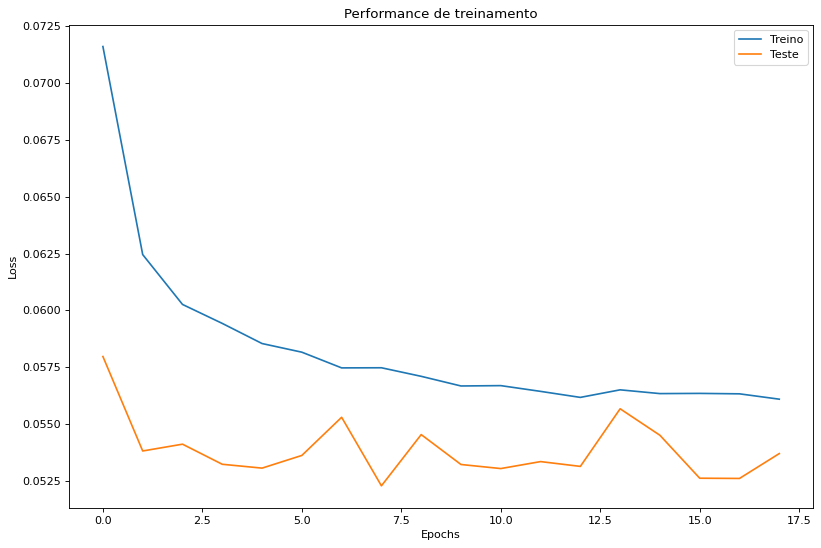

In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, restore_best_weights=True)

history_radiacao = model_radiacao.fit(train_X_radiacao, train_y_radiacao, epochs=50, validation_data=(test_X_radiacao, test_y_radiacao), 
                             callbacks=es_callback, shuffle=False, batch_size=32, verbose=1)

plt.figure(figsize=(12,8), dpi = 80, facecolor='w', edgecolor='k')
plt.title('Performance de treinamento')
plt.plot(history_radiacao.history['loss'], label='Treino')
plt.plot(history_radiacao.history['val_loss'], label='Teste')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_X = test_X_radiacao
test_y = test_y_radiacao

O RMSE do set de testes foi de 0.096



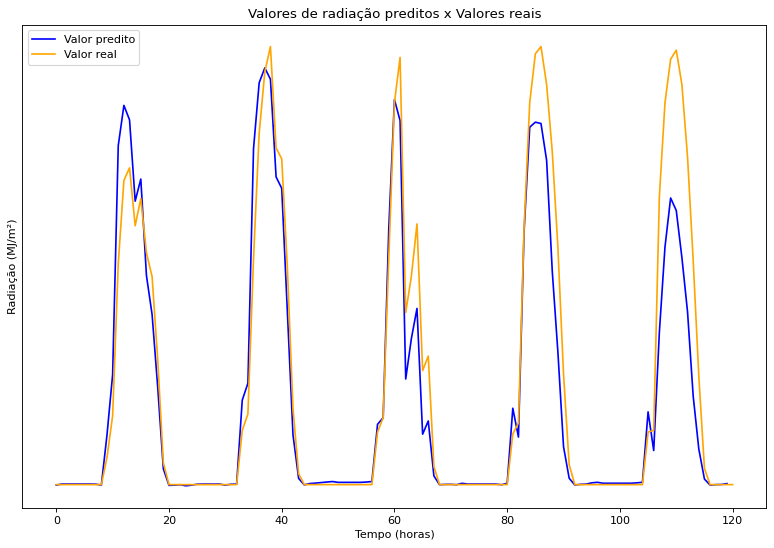

In [ ]:
# Realiza a predicao
y_pred = model_radiacao.predict(test_X)

# Calcula a raiz quadrada do erro medio quadratico
rmse = sqrt(mean_squared_error(y_pred, test_y))
print(f'O RMSE do set de testes foi de {rmse:.3f}\n')

plt.figure(figsize=(12,8), dpi = 80, facecolor='w', edgecolor='k')
plt.title('Valores de radiação preditos x Valores reais')
plt.xlabel('Tempo (horas)')
plt.ylabel('Radiação (MJ/m²)')
plt.plot(y_pred[-120:], color='blue', label='Valor predito')
plt.plot(test_y[-121:], color='orange', label='Valor real')
plt.yticks([])
plt.legend()
plt.show()

In [ ]:
values_velvento = reframed_velvento.values
split_fraction_velvento = 0.8

# Divide o dataset de vento em sets de treino e de teste
train_size_velvento = int(len(values_velvento) * split_fraction_velvento)
train_velvento = values_velvento[:train_size_velvento, :]
test_velvento = values_velvento[train_size_velvento:, :]

# Divide os sets de treino e de teste em entradas e saidas
train_X_velvento, train_y_velvento = train_velvento[:, :-1], train_velvento[:, -1]
test_X_velvento, test_y_velvento = test_velvento[:, :-1], test_velvento[:, -1]

# Remodela a entrada no formato 3D [amostras, timesteps, features]
train_X_velvento = train_X_velvento.reshape((train_X_velvento.shape[0], 1, train_X_velvento.shape[1]))
test_X_velvento = test_X_velvento.reshape((test_X_velvento.shape[0], 1, test_X_velvento.shape[1]))

print('---- Set de treino ----')
print(f'O set de entrada tem o formato {train_X_velvento.shape} e o de saida {train_y_velvento.shape}')
print('\n---- Set de teste ----')
print(f'O set de entrada tem o formato {test_X_velvento.shape} e o de saida {test_y_velvento.shape}')

---- Set de treino ----
O set de entrada tem o formato (71166, 1, 4) e o de saida (71166,)

---- Set de teste ----
O set de entrada tem o formato (17792, 1, 4) e o de saida (17792,)


In [ ]:
model_velvento = tf.keras.models.Sequential()
model_velvento.add(tf.keras.layers.LSTM(32, input_shape=(train_X_velvento.shape[1], train_X_velvento.shape[2]), return_sequences=True))
model_velvento.add(tf.keras.layers.Dropout(0.2)),
model_velvento.add(tf.keras.layers.LSTM(units=64,return_sequences=True)),
model_velvento.add(tf.keras.layers.Dropout(0.3)),
model_velvento.add(tf.keras.layers.LSTM(units=128,return_sequences=True)),
model_velvento.add(tf.keras.layers.Dropout(0.4)),
model_velvento.add(tf.keras.layers.LSTM(units=128,return_sequences=True)),
model_velvento.add(tf.keras.layers.Dropout(0.4)),
model_velvento.add(tf.keras.layers.LSTM(units=64,return_sequences=True)),
model_velvento.add(tf.keras.layers.Dropout(0.3)),
model_velvento.add(tf.keras.layers.LSTM(units=32,return_sequences=False)),
model_velvento.add(tf.keras.layers.Dropout(0.2)),
model_velvento.add(tf.keras.layers.Dense(1)),
model_velvento.compile(optimizer='adam', loss='mse')

Epoch 1/100
2224/2224 [==============================] - 38s 14ms/step - loss: 0.0194 - val_loss: 0.0166
Epoch 2/100
2224/2224 [==============================] - 26s 12ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 3/100
2224/2224 [==============================] - 23s 10ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 4/100
2224/2224 [==============================] - 25s 11ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 5/100
2224/2224 [==============================] - 25s 11ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 6/100
2224/2224 [==============================] - 23s 11ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 7/100
2224/2224 [==============================] - 26s 11ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 8/100
2224/2224 [==============================] - 23s 10ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 9/100
2224/2224 [==============================] - 25s 11ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 10/100
2224/2224 [==============================]

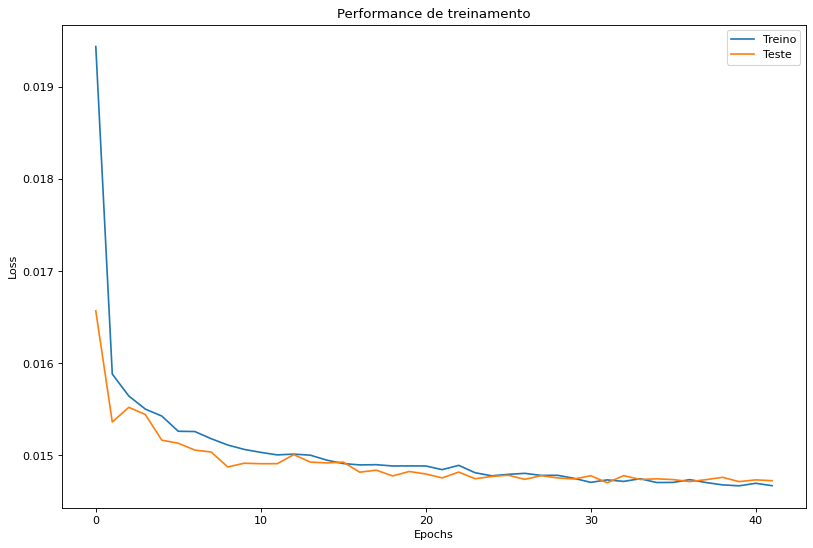

In [ ]:
history_velvento = model_velvento.fit(train_X_velvento, train_y_velvento, epochs=100, validation_data=(test_X_velvento, test_y_velvento), 
                             callbacks=es_callback, shuffle=False, batch_size=32, verbose=1)

plt.figure(figsize=(12,8), dpi = 80, facecolor='w', edgecolor='k')
plt.title('Performance de treinamento')
plt.plot(history_velvento.history['loss'], label='Treino')
plt.plot(history_velvento.history['val_loss'], label='Teste')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test RMSE: 0.121


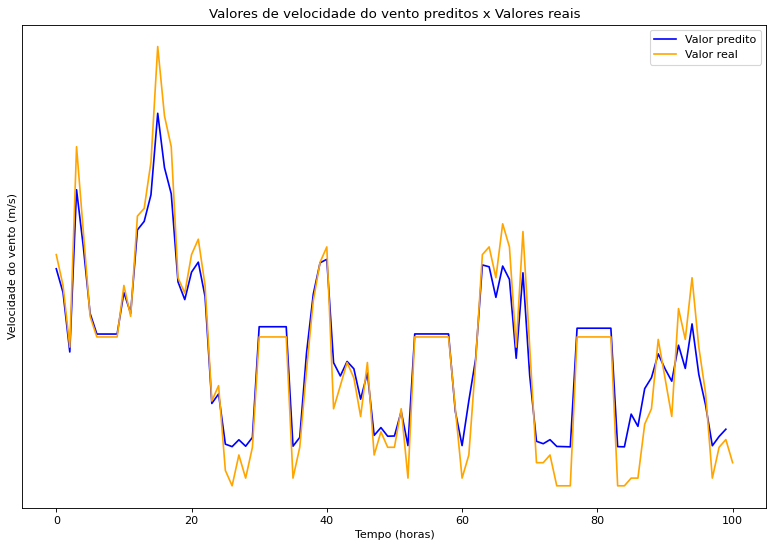

In [ ]:
# make a prediction
yhat = model_velvento.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
rmse = sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(12,8), dpi = 80, facecolor='w', edgecolor='k')
#plt.plot(inv_yhat[-100:])
#plt.plot(inv_y[-101:])

plt.title('Valores de velocidade do vento preditos x Valores reais')
plt.xlabel('Tempo (horas)')
plt.ylabel('Velocidade do vento (m/s)')
plt.plot(yhat[-100:], color='blue', label='Valor predito')
plt.plot(test_y[-101:], color='orange', label='Valor real')
plt.yticks([])
plt.legend()
plt.show()